***Extractive step: BioBERT, K means***

pipeline:
I use BioBERT for embdeddings

I use Spacy for sentence segmentation 



In [ ]:
!pip install -q spacy
!python -m spacy download en_core_web_sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import typing
from pprint import pprint
import os
import pickle
import gc

from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.cluster import KMeans
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm

import spacy
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")


# Check if MPS is available and set the device accordingly
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device.")
    os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = "0.0"
    print(os.getenv('PYTORCH_MPS_HIGH_WATERMARK_RATIO'))
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print('There is CUDA GPU available!')
    max_split_size_mb = 256  # Set the max_split_size_mb value (e.g., 512 MB)
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = f"max_split_size_mb:{max_split_size_mb}"
    print(f"PYTORCH_CUDA_ALLOC_CONF is set to: {os.environ['PYTORCH_CUDA_ALLOC_CONF']}")
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
else:
    device = torch.device("cpu")
    print("MPS not available. Using CPU.")

# Load the dataset and cut down
dataset = load_dataset("allenai/mslr2022", "ms2", split='train')
# Use select to create a subset
# dataset = dataset.select(range(20,21))

# Initialize the BioBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = typing.cast(BertModel, BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1').to(device))

csv_file_path = 'biobert_extractive_only_training_dataset.csv'

Using MPS (Metal Performance Shaders) device.
0.0


/Users/michaelenghoekhor/Downloads/pytorch-test/env/lib/python3.8/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
def bert_sentence_embeddings(sentences: typing.List[str]):
    # Move inputs to the device
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Move outputs back to CPU and compute mean
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    # clear GPU memory
    del inputs, outputs
    # torch.mps.empty_cache()
    torch.cuda.empty_cache()
    gc.collect()

    return embeddings


def select_top_sentences(sentences, embeddings, n_sentences=5):
    # this is fixed : each selected sentence is from a different cluster
    if len(sentences) <= n_sentences:
        return ' '.join(sentences)

    kmeans = KMeans(n_clusters=n_sentences, n_init=10)
    kmeans.fit(embeddings)

    # Initialize a set to store indices of selected sentences
    selected_indices = set()
    top_sentences = []
    top_sentences_indices = []

    for i in range(n_sentences):
        # Calculate distances of all sentences from the i-th centroid
        distances = np.linalg.norm(embeddings - kmeans.cluster_centers_[i], axis=1)

        # Sort the sentences by their distance from the centroid
        sorted_indices = np.argsort(distances)

        # Find the closest sentence that hasn't been selected yet
        for index in sorted_indices:
            if index not in selected_indices:
                selected_indices.add(index)
                top_sentences.append(sentences[index])
                top_sentences_indices.append(index)
                break

    return ' '.join([sentences[i] + ("" if sentences[i].endswith(".") else ".") for i in sorted(top_sentences_indices)])


save_path = "biobert_extractive_only_training_dataset"
# save_path = "/content/drive/MyDrive/266: NLP/266 final project/extractive_abstractive/biobert_kmeans_training_mk/extractive_output"  # for Colab
# save_path = "/content/drive/MyDrive/266 final project/extractive_abstractive/biobert_kmeans_training_mk/extractive_output"  # for Colab


def process_row(row):
    review_id = row['review_id']
    abstract_list = row['abstract']

    # check if saved
    if os.path.exists(f'{save_path}/{review_id}.pkl'):
        with open(f'{save_path}/{review_id}.pkl', 'rb') as file:
            ret = pickle.load(file)

    else:
        combined_summary = ''

        all_sentences = []
        all_embeddings = []

        for abstract in abstract_list:
            # Check if the abstract is a string; if not, join it into a single string
            abstract_text = ' '.join(abstract) if isinstance(abstract, list) else abstract

            # Use SpaCy for sentence segmentation
            doc = nlp(abstract_text)
            sentences = [sent.text.strip() for sent in doc.sents]
            all_sentences.append(sentences)

            # Generate embeddings for each sentence
            embeddings = bert_sentence_embeddings(sentences)
            all_embeddings.extend(embeddings)
            # Select the top sentences from these embeddings
            summary = select_top_sentences(sentences, embeddings)

            # Combine the summaries from each abstract
            combined_summary += summary + (' ' if summary.endswith(".") else ". ")

        # intermediate save
        with open(f'{save_path}/{review_id}.pkl', 'wb') as file:
            ret = {
                "review_id": review_id,
                "summary": combined_summary.strip(),
                "sentences": all_sentences,  # save all to disk
                "embeddings": all_embeddings,
            }
            pickle.dump(ret, file)

    # get rid of sentences and embeddings
    del ret['sentences']
    del ret['embeddings']
    return ret


# Apply the function to each element of the dataset
summaries_dataset = dataset.map(process_row, num_proc=1)  # CHANGE THIS APPROPRIATELY

# Saving the dataset
with open(f'{save_path}/biobert_extractive_only_training_dataset.pkl', 'wb') as file:
    pickle.dump(summaries_dataset, file)


# Convert to pandas DataFrame
df = pd.DataFrame(summaries_dataset)
df = df[['review_id', 'summary']]

# Save to CSV
df.to_csv(csv_file_path, index=True)

print(f"Saved summaries to {csv_file_path}")

# disconnect Google Colab
from google.colab import runtime
runtime.unassign()

In [23]:
# Reminder of what training dataset looks like
dataset

Dataset({
    features: ['review_id', 'pmid', 'title', 'abstract', 'target', 'background'],
    num_rows: 14188
})

In [20]:
# The above was run across multiple devices. Combined results are available in experiment_1/biobert_extractive_only_training_dataset_zipped in separate zipped files.
# 1. Initiate an empty dict
# 2. For each zipped file:
# 2.1. Unzip a zipped file
# 2.2. Iterate through the unzipped files (pkl files):
# 2.2.1. Verify that the file belongs to `dataset`
# 2.2.2. Retrieve the review_id and summary
# 2.2.3. Update dict with review_id as key and summary as value
# 2.3. Delete the unzipped files
# 2.4. Intermittently save the dict to disk
# 3. Convert the dict to a pandas DataFrame, save it.

RELATIVE_PATH_TO_ZIPPED_FILES = "biobert_extractive_only_training_dataset_zipped"

# 1. Initiate an empty dict
combined_dict = {}
bad_files = []

# 2. For each zipped file:
for i, zipfile in enumerate(os.listdir(RELATIVE_PATH_TO_ZIPPED_FILES)):
    # 2.1. Unzip a zipped file
    print(f"Unzipping {zipfile}")
    !unzip -q "{RELATIVE_PATH_TO_ZIPPED_FILES}/{zipfile}" -d "biobert_extractive_only_training_dataset_zipped_{i}"
    # 2.2. Iterate through the unzipped files (pkl files):
    for file in tqdm(os.listdir(f"biobert_extractive_only_training_dataset_zipped_{i}/extractive_output")):
        if file.endswith(".pkl"):
            # 2.2.1. Verify that the file belongs to `dataset`
            review_id = file.split('.')[0]
            if not review_id in dataset["review_id"]:
                bad_files.append(file)
                continue

            # 2.2.2. Retrieve the review_id and summary
            with open(f"biobert_extractive_only_training_dataset_zipped_{i}/extractive_output/{file}", 'rb') as f:
                file_contents = pickle.load(f)
                review_id = file_contents['review_id']
                summary = file_contents['summary']
                # 2.2.3. Update dict with review_id as key and summary as value
                combined_dict[review_id] = summary

    # 2.3. Delete the unzipped files
    !rm -rf biobert_extractive_only_training_dataset_zipped_{i}
    # 2.4. Intermittently save the dict to disk
    with open("biobert_extractive_only_training_dataset.pkl", 'wb') as f:
        pickle.dump(combined_dict, f)

    gc.collect()


# 3. Convert the dict to a pandas DataFrame, save it.
df = pd.DataFrame.from_dict(combined_dict, orient='index', columns=['summary'])
df.index.name = 'review_id'
# save compressed
df.to_csv("biobert_extractive_only_training_dataset.csv.gz", compression='gzip')

Unzipping extractive_output-20231202T030259Z-004.zip


100%|██████████| 2389/2389 [00:20<00:00, 117.97it/s]


Unzipping extractive_output-20231202T030259Z-005.zip


100%|██████████| 2146/2146 [00:18<00:00, 114.50it/s]


Unzipping extractive_output-20231202T030259Z-006.zip


100%|██████████| 1635/1635 [00:14<00:00, 116.76it/s]


Unzipping extractive_output-20231202T030259Z-002.zip


100%|██████████| 2566/2566 [00:21<00:00, 119.52it/s]


Unzipping extractive_output-20231202T030259Z-003.zip


100%|██████████| 2464/2464 [00:20<00:00, 118.55it/s]


Unzipping extractive_output-20231202T030259Z-001.zip


100%|██████████| 3002/3002 [00:24<00:00, 120.70it/s]


In [25]:
df.to_csv("biobert_extractive_only_training_dataset.csv.gz", compression='gzip')

In [26]:
# to open gzip pandas csv file
df = pd.read_csv("biobert_extractive_only_training_dataset.csv.gz", compression='gzip', index_col=0)

In [27]:
df.shape

(14188, 1)

In [29]:
df.head()

,summary
review_id,
19277023,METHODS Forty-eight patients with Rome II IBS ...
25108741,"Therefore , improved approaches to smoking ces..."
23052919,Summary : We initiated a r and omized study of...
25019658,DESIGN R and omized controlled trial . INTERVE...
26677846,We investigated the combination of pertuzumab ...


In [ ]:
# count how many files are in the directory
import os
from tqdm import tqdm
print("total generated:", len(os.listdir(save_path)))
print("total expected:", len(dataset))

# if there are any missing from `dataset`, list them. infer from file name
missing = []
for review_id in tqdm(dataset['review_id']):
    if not os.path.exists(f'{save_path}/{review_id}.pkl'):
        missing.append(review_id)

print(len(missing))

In [95]:
with open('biobert_extractive_only_training_dataset/15106233.pkl', 'rb') as file:
    investigate_pkl = pickle.load(file)

pprint(investigate_pkl['sentences'], width=200)

[['The influence of diurnal variations of mood ( DVM ) and sleep disturbances on treatment response was investigated in 42 patients with major depressive disorder ( not SAD ) under the treatment of '
  'either bright white light ( 2,500 lx ) or dim red light ( 50 lx ) .',
  'We found only a slight influence in certain subscales of DVM and no influence of sleep disturbances .',
  'These results are discussed under a clinical point of view and with respect to phase shift theories of depressive disorders'],
 ['In a group of 17 patients with non-SAD depressive disorders we compared the response of bipolar spectrum versus unipolar patients to treatment with light therapy .',
  'The main hypothesis was that bipolar spectrum depressed patients would preferentially respond to bright light therapy as compared to unipolar depressed patients .',
  'All patients were treated with either 400 or 2500 lux phototherapy for 2 h on seven consecutive days .',
  'All outcome measures , which included the 

In [76]:
pprint(summaries_dataset["summary"][0], width=200)

('METHODS We conducted a double-blind , r and omized clinical trial to investigate whether levosimendan reduces the severity of organ dysfunction in adults with sepsis . The primary outcome was the '
 'mean daily Sequential Organ Failure Assessment ( SOFA ) score in the intensive care unit up to day 28 ( scores for each of five systems range from 0 to 4 , with higher scores indicating more '
 'severe dysfunction ; maximum score , 20 ) . More patients in the levosimendan group than in the placebo group had supraventricular tachyarrhythmia ( 3.1 % vs. 0.4 % ; absolute difference , 2.7 '
 'percentage points ; 95 % CI , 0.1 to 5.3 ; P=0.04 ) . CONCLUSIONS The addition of levosimendan to st and ard treatment in adults with sepsis was not associated with less severe organ dysfunction '
 'or lower mortality . ( Funded by the NIHR Efficacy and Mechanism Evaluation Programme and others ; LeoPARDS Current Controlled Trials number , IS RCT N12776039 . ). Methods and Results — In this '
 'prospect

<Axes: >

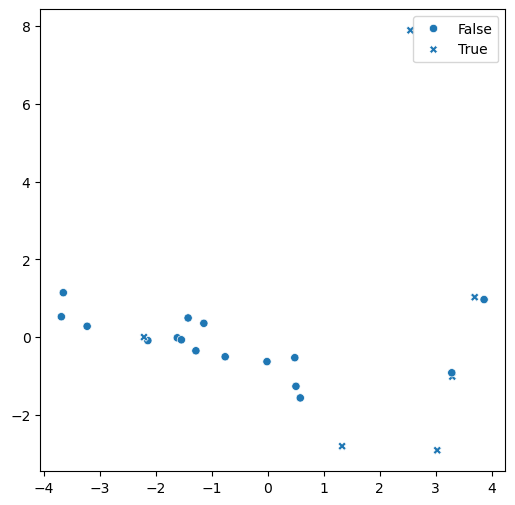

In [81]:
# view embeddings in reduced dimension, for the first abstract only
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)

#  filter by one abstract only
abstract_id = 9

# get relevant embeddings rows based on chosen abstract and its position in sentences
start_sentence_id = sum([len(sentences) for sentences in summaries_dataset['sentences'][0][:abstract_id]])
end_sentence_id = start_sentence_id + len(summaries_dataset['sentences'][0][abstract_id])

relevant_embeddings = summaries_dataset['embeddings'][0][start_sentence_id:end_sentence_id]
pca.fit(relevant_embeddings)
embeddings_2d = pca.transform(relevant_embeddings)

# was a sentence selected? check in `summary` (string)
selected = []
for i in range(len(summaries_dataset['sentences'][0][abstract_id])):
    selected.append(summaries_dataset['sentences'][0][abstract_id][i] in summaries_dataset['summary'][0])

# plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1], style=selected)
